In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import numpy as np
from datetime import timedelta, date

from obspy.imaging.cm import obspy_sequential, obspy_divergent
from obspy.signal import util

from os import listdir
from os.path import isfile, join

import binascii
import struct

/root/anaconda3/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


In [2]:

def plot_wps (t):

    A1 = 4.
    t1 = .001
    f1 = .001
    phi1 = 0.1

    # generate the signal
    H1 = (np.sign(t - t1) + 1) / 2
    st1 = A1 * (t - t1) * np.exp(-2 * (t - t1))
    st1 *= np.cos(2. * np.pi * f1 * (t - t1) + phi1 * np.pi) * H1
    
    return st1


In [3]:
motor = '1Y520210304'
# load_path = '../datasets/phm-2012/Learning_set/' + motor + '/'
# load_path = '../datasets/csc/1Y520210106/1/2/' 
npy_save_path = '../datasets/csc/1Y520210304-wt/'
img_save_path = '../datasets/csc/1Y520210304-image/'

In [4]:
def hexint(b,bReverse=True): 
    return int(binascii.hexlify(b[::-1]), 16) if bReverse else int(binascii.hexlify(b), 16)

In [5]:
def convert_bin (filename):
    bytes_read = open(filename, "rb").read()
    size = [hexint(bytes_read[(i*4):((i+1)*4)]) for i in range(2)]
    signal = [struct.unpack('f',bytes_read[(i*4):((i+1)*4)]) for i in range(2,2+size[0]*size[1])]
    data = np.array(signal).reshape(size)
    return_df = pd.DataFrame(data = data)
    return_df = return_df.T

    return return_df

In [6]:
def cwt(st, dt, w0, fmin, fmax, nf=100, wl='morlet'):
    """
    Continuous Wavelet Transformation in the Frequency Domain.
    .. seealso:: [Kristekova2006]_, eq. (4)
    :param st: time dependent signal.
    :param dt: time step between two samples in st (in seconds)
    :param w0: parameter for the wavelet, tradeoff between time and frequency
        resolution
    :param fmin: minimum frequency (in Hz)
    :param fmax: maximum frequency (in Hz)
    :param nf: number of logarithmically spaced frequencies between fmin and
        fmax
    :param wl: wavelet to use, for now only 'morlet' is implemented
    :return: time frequency representation of st, type numpy.ndarray of complex
        values, shape = (nf, len(st)).
    """
    npts = len(st) * 2
    tmax = (npts - 1) * dt
    t = np.linspace(0., tmax, npts)
    f = np.logspace(np.log10(fmin), np.log10(fmax), nf)

    cwt = np.zeros((npts // 2, nf), dtype=np.complex)

    if wl == 'morlet':

        def psi(t):
            return np.pi ** (-.25) * np.exp(1j * w0 * t) * \
                np.exp(-t ** 2 / 2.)

        def scale(f):
            return w0 / (2 * np.pi * f)
    else:
        raise ValueError('wavelet type "' + wl + '" not defined!')

    nfft = util.next_pow_2(npts) * 2
    sf = np.fft.fft(st, n=nfft)

    # Ignore underflows.
    with np.errstate(under="ignore"):
        for n, _f in enumerate(f):
            a = scale(_f)
            # time shift necessary, because wavelet is defined around t = 0
            psih = psi(-1 * (t - t[-1] / 2.) / a).conjugate() / np.abs(a) ** .5
            psihf = np.fft.fft(psih, n=nfft)
            tminin = int(t[-1] / 2. / (t[1] - t[0]))
            cwt[:, n] = np.fft.ifft(psihf * sf)[tminin:tminin + npts // 2] * \
                (t[1] - t[0])

    return cwt.T

In [7]:
def plot_tfr(st, dt=0.01, t0=0., fmin=1., fmax=10., nf=100, w0=6, left=0.1,
             bottom=0.1, h_1=0.2, h_2=0.6, w_1=0.2, w_2=0.6, w_cb=0.01,
             d_cb=0.0, show=True, plot_args=['k', 'k'], clim=0.0,
             cmap=obspy_sequential, mode='absolute', fft_zero_pad_fac=0, figure_name='test.png'):
    """
    Plot time frequency representation, spectrum and time series of the signal.
    :param st: signal, type numpy.ndarray with shape (number of components,
        number of time samples) or (number of timesamples, ) for single
        component data
    :param dt: time step between two samples in st
    :param t0: starting time for plotting
    :param fmin: minimal frequency to be analyzed
    :param fmax: maximal frequency to be analyzed
    :param nf: number of frequencies (will be chosen with logarithmic spacing)
    :param w0: parameter for the wavelet, tradeoff between time and frequency
        resolution
    :param left: plot distance from the left of the figure
    :param bottom: plot distance from the bottom of the figure
    :param h_1: height of the signal axis
    :param h_2: height of the TFR/spectrum axis
    :param w_1: width of the spectrum axis
    :param w_2: width of the TFR/signal axes
    :param w_cb: width of the colorbar axes
    :param d_cb: distance of the colorbar axes to the other axes
    :param show: show figure or return
    :param plot_args: list of plot arguments passed to the signal and spectrum
        plots
    :param clim: limits of the colorbars
    :param cmap: colormap for TFEM/TFPM, either a string or
        matplotlib.cm.Colormap instance
    :param mode: 'absolute' for absolute value of TFR, 'power' for ``|TFR|^2``
    :param fft_zero_pad_fac: integer, if > 0, the signal is zero padded to
        ``nfft = next_pow_2(len(st)) * fft_zero_pad_fac`` to get smoother
        spectrum in the low frequencies (has no effect on the TFR and might
        make demeaning/tapering necessary to avoid artifacts)
    :return: If show is False, returns a matplotlib.pyplot.figure object
        (single component data) or a list of figure objects (multi component
        data)
    .. rubric:: Example
    >>> from obspy import read
    >>> tr = read("https://examples.obspy.org/a02i.2008.240.mseed")[0]
    >>> plot_tfr(tr.data, dt=tr.stats.delta, fmin=.01, # doctest: +SKIP
    ...         fmax=50., w0=8., nf=64, fft_zero_pad_fac=4)
    .. plot::
        from obspy.signal.tf_misfit import plot_tfr
        from obspy import read
        tr = read("https://examples.obspy.org/a02i.2008.240.mseed")[0]
        plot_tfr(tr.data, dt=tr.stats.delta, fmin=.01,
                fmax=50., w0=8., nf=64, fft_zero_pad_fac=4)
    """
    import matplotlib.pyplot as plt
    from matplotlib.ticker import NullFormatter
    npts = st.shape[-1]
    tmax = (npts - 1) * dt
    t = np.linspace(0., tmax, npts) + t0

    if fft_zero_pad_fac == 0:
        nfft = npts
    else:
        nfft = util.next_pow_2(npts) * fft_zero_pad_fac

    f_lin = np.linspace(0, 0.5 / dt, nfft // 2 + 1)

    if len(st.shape) == 1:
        _w = np.zeros((1, nf, npts), dtype=np.complex)
        _w[0] = cwt(st, dt, w0, fmin, fmax, nf)
        ntr = 1

        spec = np.zeros((1, nfft // 2 + 1), dtype=np.complex)
        spec[0] = np.fft.rfft(st, n=nfft) * dt

        st = st.reshape((1, npts))
    else:
        _w = np.zeros((st.shape[0], nf, npts), dtype=np.complex)
        spec = np.zeros((st.shape[0], nfft // 2 + 1), dtype=np.complex)

        for i in np.arange(st.shape[0]):
            _w[i] = cwt(st[i], dt, w0, fmin, fmax, nf)
            spec[i] = np.fft.rfft(st[i], n=nfft) * dt

        ntr = st.shape[0]

    if mode == 'absolute':
        _tfr = np.abs(_w)
        spec = np.abs(spec)
    elif mode == 'power':
        _tfr = np.abs(_w) ** 2
        spec = np.abs(spec) ** 2
    else:
        raise ValueError('mode "' + mode + '" not defined!')

    figs = []

    for itr in np.arange(ntr):
        fig = plt.figure()

        # plot signals
#         ax_sig = fig.add_axes([left + w_1, bottom, w_2, h_1])
#         ax_sig.plot(t, st[itr], plot_args[0])

        # plot TFR
        ax_tfr = fig.add_axes([left + w_1, bottom + h_1, w_2, h_2])

        x, y = np.meshgrid(
            t, np.logspace(np.log10(fmin), np.log10(fmax),
                           _tfr[itr].shape[0]))
        img_tfr = ax_tfr.pcolormesh(x, y, _tfr[itr], cmap=cmap)
        
        return_numpy = img_tfr.get_array().reshape(img_tfr._meshWidth, img_tfr._meshHeight)
        
#         print(return_numpy.shape)
#         print (x.shape, y.shape, img_tfr.get_array().shape, img_tfr._meshWidth, img_tfr._meshHeight)
        
        img_tfr.set_rasterized(True)
        ax_tfr.set_yscale("log")
        ax_tfr.set_ylim(fmin, fmax)
        ax_tfr.set_xlim(t[0], t[-1])
        
        plt.axis('off')
        
#120-123        

        # plot spectrum
#         ax_spec = fig.add_axes([left, bottom + h_1, w_1, h_2])
#         ax_spec.semilogy(spec[itr], f_lin, plot_args[1])

        # add colorbars
#         ax_cb_tfr = fig.add_axes([left + w_1 + w_2 + d_cb + w_cb, bottom +
#                                   h_1, w_cb, h_2])
#         fig.colorbar(img_tfr, cax=ax_cb_tfr)

        # set limits
#         ax_sig.set_ylim(st.min() * 1.1, st.max() * 1.1)
#         ax_sig.set_xlim(t[0], t[-1])

#         xlim = spec.max() * 1.1

#         ax_spec.set_xlim(xlim, 0.)
#         ax_spec.set_ylim(fmin, fmax)

#         if clim == 0.:
#             clim = _tfr.max()

#         img_tfr.set_clim(0., clim)

#         ax_sig.set_xlabel('time')
#         ax_spec.set_ylabel('frequency')

        # remove axis labels
        ax_tfr.xaxis.set_major_formatter(NullFormatter())
        ax_tfr.yaxis.set_major_formatter(NullFormatter())

#         figs.append(fig)
    
    return img_tfr

#     if show:
#         plt.show()
        
#     else:
#         if ntr == 1:
#             return figs[0]
#         else:
#             return figs

../datasets/csc/1Y520210304/1/5/Raw Data-1-1Y520210304-14-30-01_8192.bin
../datasets/csc/1Y520210304/1/5/Raw Data-1-1Y520210304-14-40-11_8192.bin
../datasets/csc/1Y520210304/1/5/Raw Data-1-1Y520210304-14-50-21_8192.bin
../datasets/csc/1Y520210304/1/6/Raw Data-1-1Y520210304-00-40-02_8192.bin
../datasets/csc/1Y520210304/1/6/Raw Data-1-1Y520210304-00-50-12_8192.bin
../datasets/csc/1Y520210304/1/8/Raw Data-1-1Y520210304-14-00-27_8192.bin
../datasets/csc/1Y520210304/1/8/Raw Data-1-1Y520210304-14-10-37_8192.bin
../datasets/csc/1Y520210304/1/8/Raw Data-1-1Y520210304-14-20-47_8192.bin
../datasets/csc/1Y520210304/1/8/Raw Data-1-1Y520210304-14-30-57_8192.bin
../datasets/csc/1Y520210304/1/9/Raw Data-1-1Y520210304-00-00-19_8192.bin
../datasets/csc/1Y520210304/1/9/Raw Data-1-1Y520210304-00-10-29_8192.bin
../datasets/csc/1Y520210304/1/9/Raw Data-1-1Y520210304-00-20-39_8192.bin
../datasets/csc/1Y520210304/1/9/Raw Data-1-1Y520210304-00-30-49_8192.bin
../datasets/csc/1Y520210304/1/9/Raw Data-1-1Y520210

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


../datasets/csc/1Y520210304/1/19/Raw Data-1-1Y520210304-14-20-51_8192.bin
../datasets/csc/1Y520210304/1/20/Raw Data-1-1Y520210304-00-00-22_8192.bin
../datasets/csc/1Y520210304/1/20/Raw Data-1-1Y520210304-00-10-32_8192.bin
../datasets/csc/1Y520210304/1/20/Raw Data-1-1Y520210304-00-20-42_8192.bin
../datasets/csc/1Y520210304/1/20/Raw Data-1-1Y520210304-00-30-52_8192.bin
../datasets/csc/1Y520210304/1/27/Raw Data-1-1Y520210304-14-20-01_8192.bin
../datasets/csc/1Y520210304/1/27/Raw Data-1-1Y520210304-14-30-11_8192.bin
../datasets/csc/1Y520210304/1/27/Raw Data-1-1Y520210304-14-40-21_8192.bin
../datasets/csc/1Y520210304/1/27/Raw Data-1-1Y520210304-14-50-31_8192.bin
../datasets/csc/1Y520210304/1/28/Raw Data-1-1Y520210304-00-30-02_8192.bin
../datasets/csc/1Y520210304/1/28/Raw Data-1-1Y520210304-00-40-12_8192.bin
../datasets/csc/1Y520210304/1/28/Raw Data-1-1Y520210304-00-50-22_8192.bin
../datasets/csc/1Y520210304/1/30/Raw Data-1-1Y520210304-14-00-37_8192.bin
../datasets/csc/1Y520210304/1/30/Raw D

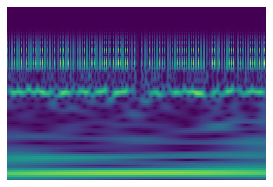

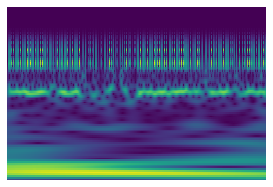

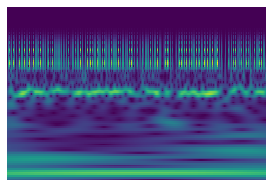

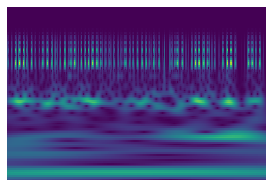

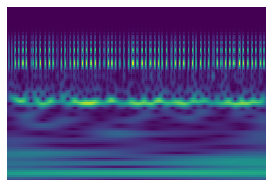

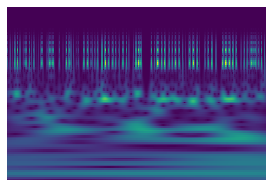

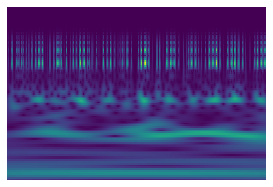

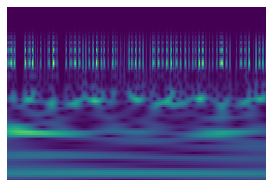

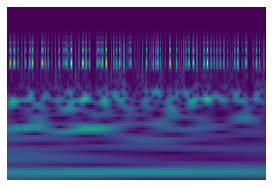

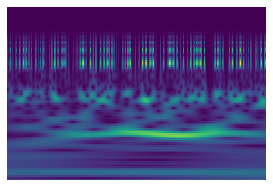

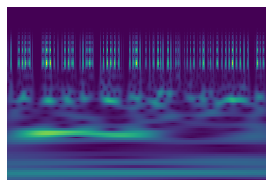

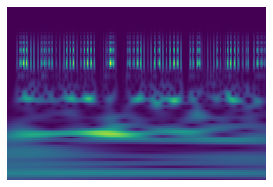

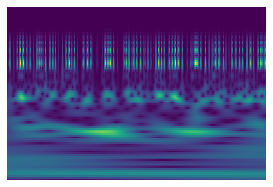

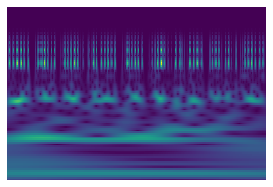

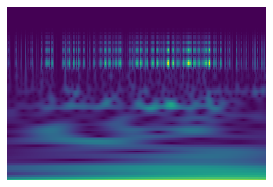

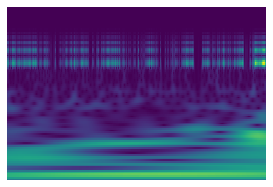

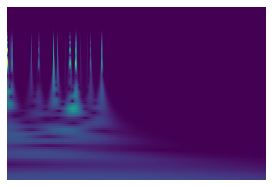

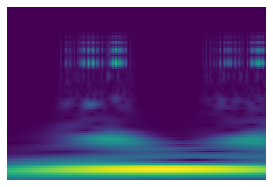

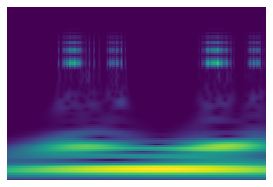

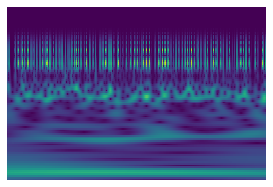

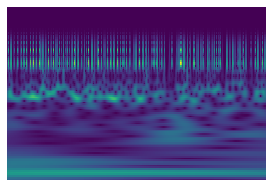

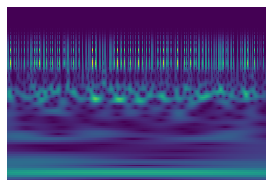

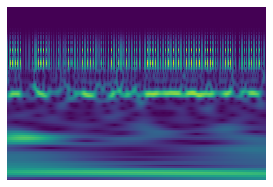

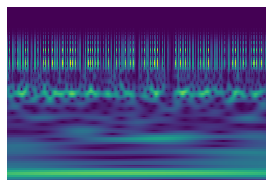

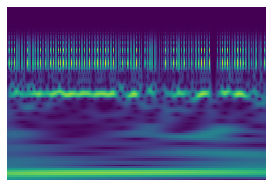

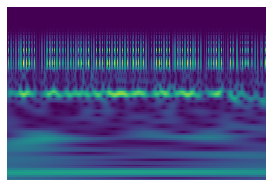

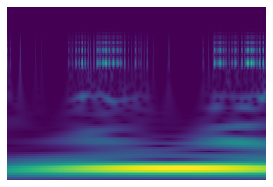

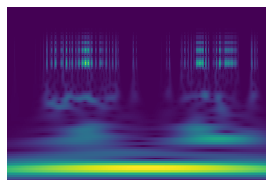

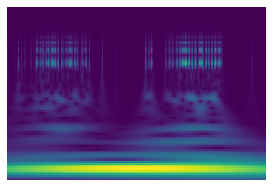

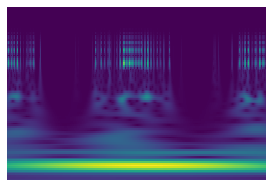

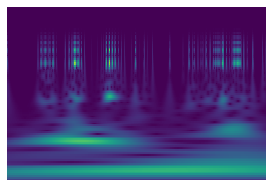

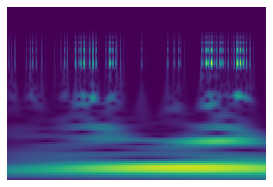

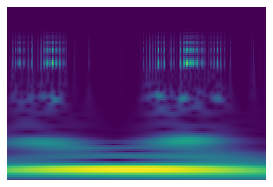

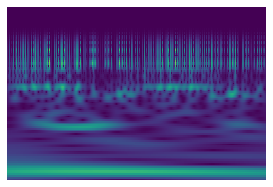

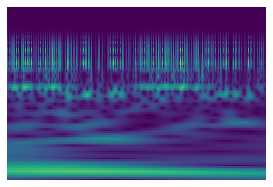

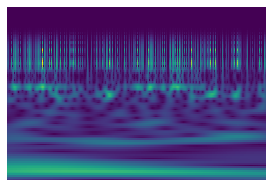

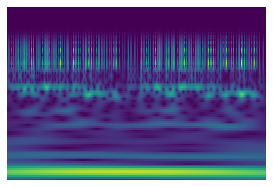

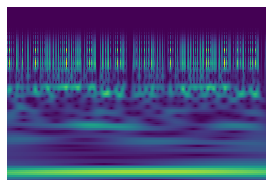

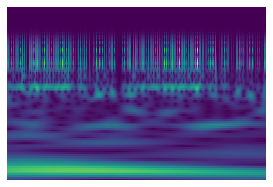

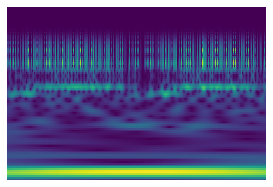

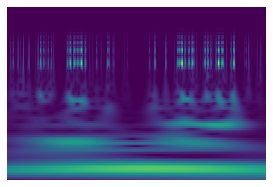

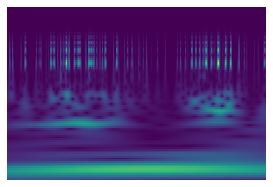

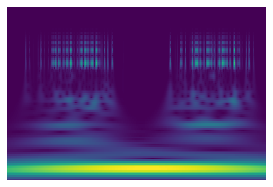

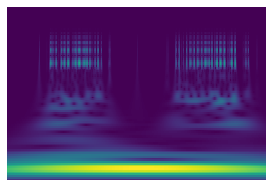

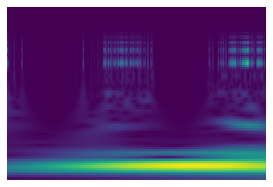

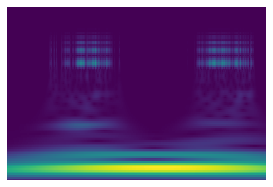

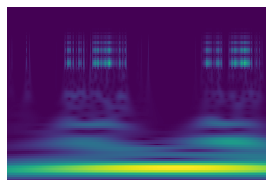

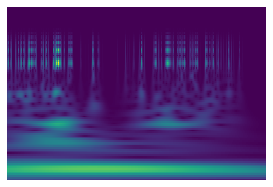

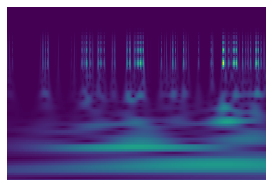

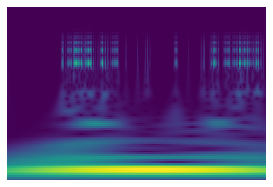

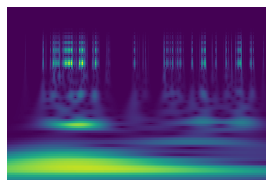

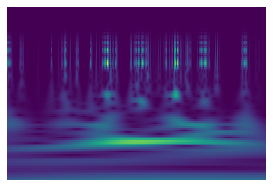

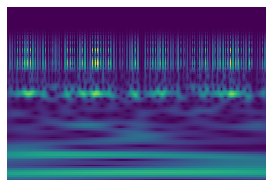

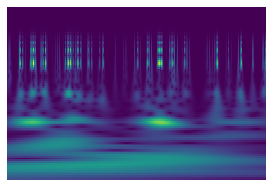

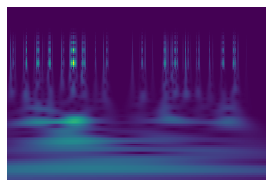

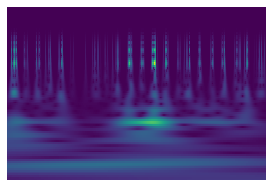

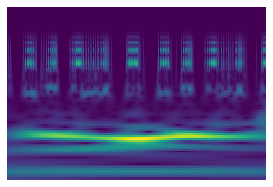

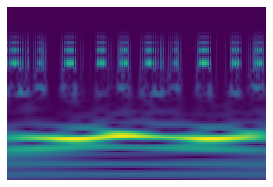

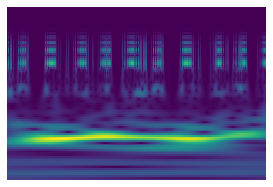

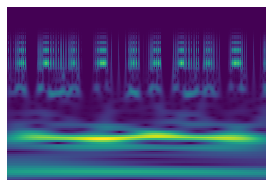

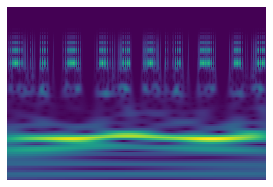

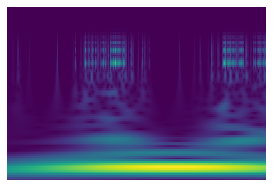

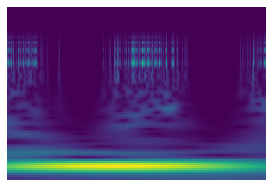

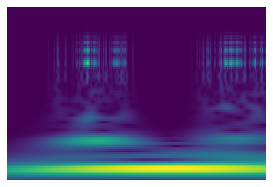

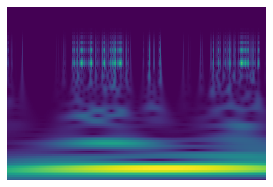

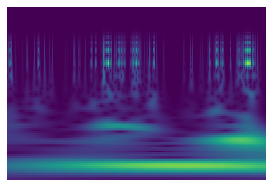

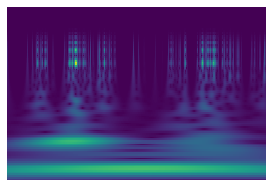

In [8]:

start_date = date(2019, 1, 1)
end_date = date(2019, 2, 28)
delta = timedelta(days=1)

file_length = int((end_date - start_date).days) * 144

x_train = np.zeros((file_length, 511, 99))
y_train = np.zeros((file_length))

c=0

while start_date <= end_date:
    
    load_path = '../datasets/csc/'+motor+'/'+str(start_date.month)+'/'+str(start_date.day)+'/' 
    
    onlyfiles = [f for f in listdir(load_path) if isfile(join(load_path, f))]
    onlyfiles.sort()
    
    for file in onlyfiles:
        
        if (int(file.split('-')[3]) % 14 == 0) & (int(file.split('-')[4]) % 10 == 0):
            print(load_path+file)
            
            dt = 0.02
            fmin = .1
            fmax = 1000      
            
            bin_pd = convert_bin(load_path+file)
            t = bin_pd.tail(512).T.values[0]
            st1 = plot_wps(t)
            img = plot_tfr(st1, dt=dt, fmin=fmin, fmax=fmax)
            
            wt_np = img.get_array().reshape(img._meshWidth, img._meshHeight)
            x_train[c, :, :] = wt_np
            y_train[c] = float(int(file.split('.')[0].split('_')[1])/len(onlyfiles))
            c=c+1
            

    start_date += delta

In [9]:
#reshape to include depth
X_train = x_train.reshape(x_train.shape[0], 1, 511,99)
#convert to float32 and normalize to [0,1]
X_train = X_train.astype('float32')
Y_train = y_train.astype('float32')
X_train /= np.amax(X_train)

In [10]:
#save dataset as numpy file

x = npy_save_path+'X_train_'+motor+'.npy'
y = npy_save_path+'Y_train_'+motor+'.npy'

print (x)
print (y)

np.save(x, X_train)
np.save(y, Y_train)


../datasets/csc/1Y520210304-wt/X_train_1Y520210304.npy
../datasets/csc/1Y520210304-wt/Y_train_1Y520210304.npy
